### Using Tree data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import *
import seaborn as sns
from tqdm.notebook import tqdm

dendro = pd.read_feather("../data/17766_12_D.feather")
dendro

,dendroNr,DOY,hour,species,growth
0,HA_001_2012,0,0.0,Beech,0.000
1,HA_001_2012,1,0.5,Beech,0.000
2,HA_001_2012,2,1.0,Beech,0.000
3,HA_001_2012,3,1.5,Beech,0.000
4,HA_001_2012,4,2.0,Beech,0.000
...,...,...,...,...,...
1457969,SH_076_2013,8779,21.5,Beech,3902.797
1457970,SH_076_2013,8780,22.0,Beech,3902.797
1457971,SH_076_2013,8781,22.5,Beech,3903.275
1457972,SH_076_2013,8782,23.0,Beech,3903.275


# Fit models

In [2]:
import jaxopt
import jax
import jax.numpy as jnp

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

In [3]:
dendro["deltagrowth"] = np.nan
weibull_params = dict()

for tree in tqdm(dendro.dendroNr.unique()):
    df_ = dendro[dendro.dendroNr.eq(tree)]
    y_ = jnp.array(df_.growth)
    x_ = jnp.array(df_.DOY)

    def f_(params):
        p0, p1, p2 = params
        return jnp.mean((y_ - (p0 * weibull_F(x_, p1, p2))) ** 2) #MSE Loss
        # return jnp.mean(
        #     jax.vmap(jax.tree_util.Partial(jaxopt.loss.huber_loss, delta = 10.))
        #     (y_, p0 * weibull_F(x_, p1, p2)) # Huber Loss
        # )

    solver = jaxopt.ScipyBoundedMinimize(fun = f_)
    res = solver.run(jnp.array([max(y_), 1/(0.632*max(y_)), 3]), jnp.array([(0.1, 0.000001, 1), (100000, 1, 100)]))
    weibull = lambda x__ : res.params[0] * weibull_F(x__.ravel(), res.params[1], res.params[2])

    with np.printoptions(precision=6, suppress=True, threshold=5, floatmode="fixed"):
        print(tree, res.params, res.state.fun_val, res.state.status, res.state.iter_num, sep = '\t')

    dendro.loc[dendro['dendroNr'] == tree, 'deltagrowth'] = y_ - weibull(x_)
    weibull_params[tree] = res.params

  0%|          | 0/170 [00:00<?, ?it/s]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


HA_001_2012	[2325.300293    0.000208    3.059213]	1150.251	0	15
HA_001_2013	[2648.443848    0.000221    3.080484]	10787.054	0	12
HA_002_2012	[1834.312866    0.000189    3.125353]	11573.764	0	11
HA_002_2013	[1213.062622    0.000189    2.988301]	10204.694	0	11
HA_003_2012	[850.643982   0.000234   2.785770]	4992.403	0	15
HA_003_2013	[814.996582   0.000304   1.863725]	45526.035	0	13
HA_004_2012	[1382.185791    0.000234    3.984756]	3625.361	0	33
HA_004_2013	[1170.805908    0.000221    3.108992]	12463.793	0	15
HA_005_2012	[610.479187   0.000238   3.907632]	3400.6377	0	16
HA_005_2013	[1321.545288    0.000219    2.789534]	10498.697	0	11
HA_006_2012	[1690.868408    0.000187    3.058059]	1297.3147	0	11
HA_006_2013	[2572.877930    0.000218    3.677077]	5516.5337	0	14
HA_010_2012	[1117.120239    0.000200    3.041751]	6816.0405	0	11
HA_010_2013	[1310.893799    0.000212    2.889742]	9145.281	0	9
HA_011_2012	[2856.686523    0.000203    2.893386]	1823.8009	0	19
HA_011_2013	[2360.338623    0.000215   

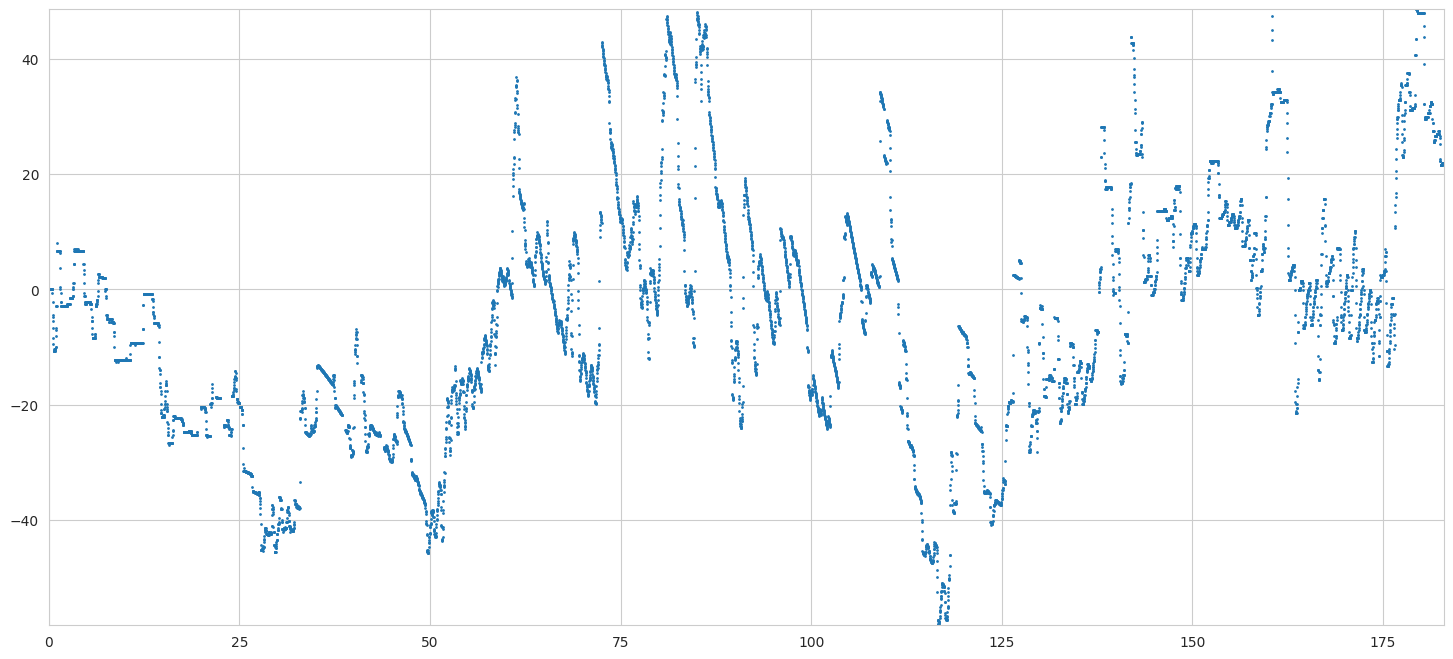

In [4]:
plt.figure(figsize=(18,8))

for i, tree in enumerate(dendro.dendroNr.unique()):
    if tree == "SH_059_2012":
        df__ = dendro[dendro.dendroNr.eq(tree)]
        plt.scatter(df__.DOY / 48, df__.deltagrowth, c = f"C{0 if '2012' in tree else 3}", alpha=1, s = 1)
    # plt.plot(dendro[dendro.dendroNr.eq(tree)].DOY, dendro[dendro.dendroNr.eq(tree)].deltagrowth,
    #          c = f"C{0 if '2012' in tree else 3}", alpha=.1)
plt.autoscale(tight=True)
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

65.3**2 * Matern(length_scale=25, nu=2.5) + WhiteKernel(noise_level=0.1) + 0.4**2 * ExpSineSquared(length_scale=0.1, periodicity=48)
65.3**2 * Matern(length_scale=25, nu=2.5) + WhiteKernel(noise_level=0.1) + 0.4**2 * ExpSineSquared(length_scale=0.1, periodicity=48)
65.3**2 * Matern(length_scale=25, nu=2.5) + WhiteKernel(noise_level=0.1) + 0.4**2 * ExpSineSquared(length_scale=0.1, periodicity=48)


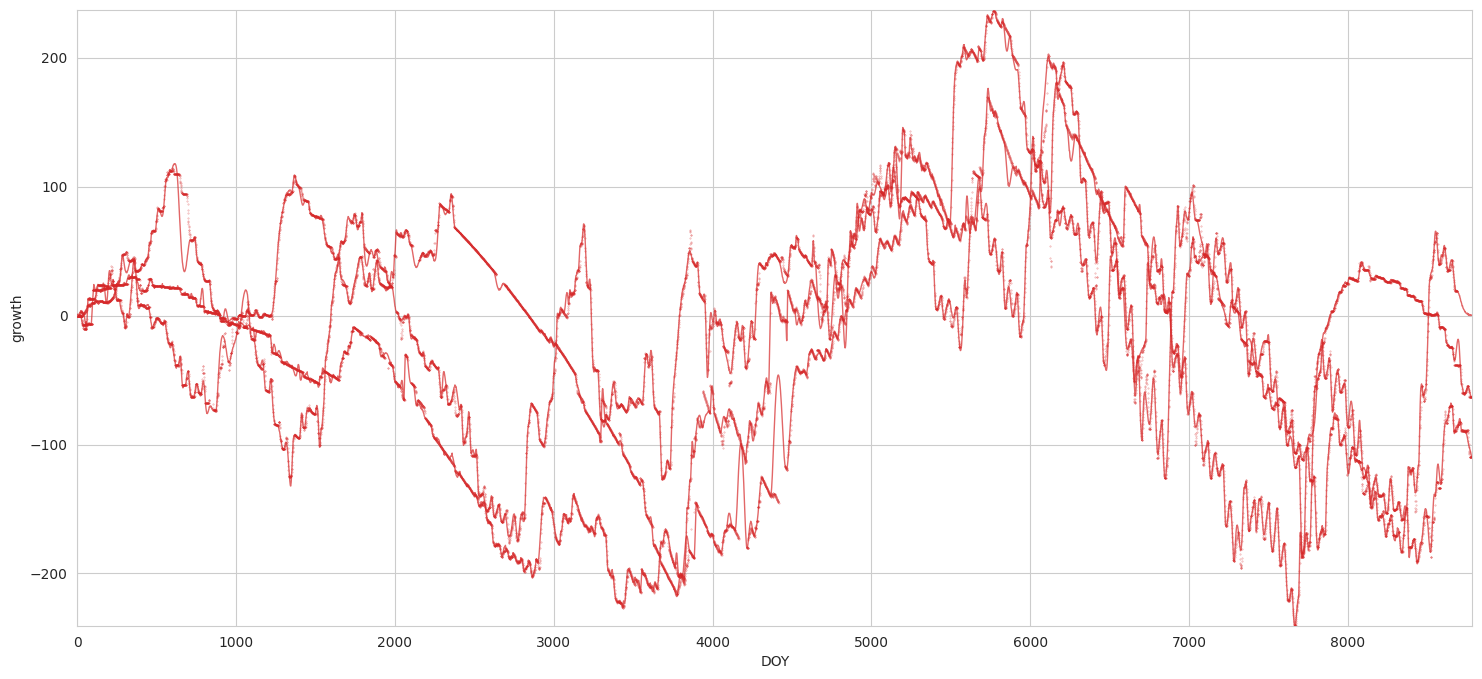

In [62]:
#tree = 'SH_076_2013'

plt.figure(figsize=(18, 8))

rng = np.random.default_rng()

X_test = np.linspace(0, dendro.DOY.max(), 6000).reshape(-1, 1)

c = lambda s : 0 if s == "Beech" else (3 if s == "Sycamore" else 1)
for tree in tqdm(dendro.dendroNr.unique().tolist()[2:5]):
    df_ = dendro.loc[dendro.dendroNr.eq(tree)]

    idx_train = np.sort(rng.integers(0, len(df_.DOY) - 1, 1000))

    X_train = df_.DOY.iloc[idx_train].array.reshape(-1, 1)
    y_train = df_.deltagrowth.iloc[idx_train]

    kernel_ = 65.3**2 * Matern(length_scale=25, length_scale_bounds=(2,16*48), nu = 2.5) + WhiteKernel(noise_level=0.1, noise_level_bounds="fixed") + ConstantKernel(0.4**2) * ExpSineSquared(0.1, 48, periodicity_bounds="fixed")
    gp_model = gaussian_process.GaussianProcessRegressor(
        kernel=kernel_,
        n_restarts_optimizer=5,
        #normalize_y=True,
        optimizer=None
    )

    gp_model.fit(X_train, y_train); print(gp_model.kernel_)
    mean_pred, std_pred = gp_model.predict(X_test, True)

    # y_samples = gp_model.sample_y(X_test, 1)

    weibull_pred = 0#weibull_params[tree][0] * weibull_F(X_test.ravel(), *weibull_params[tree][1:3])

    plt.plot(X_test, mean_pred + weibull_pred, lw=1, zorder=10, alpha = .7, color=sns.color_palette()[c(df_.species.iloc[0])])

    plt.scatter(df_.DOY, df_.deltagrowth, lw=1, zorder=1, alpha = .5, color=sns.color_palette()[c(df_.species.iloc[0])], s = .1)

    # plt.fill_between(
    #     X_test.ravel(),
    #     mean_pred + weibull_pred - 1.96 * std_pred,
    #     mean_pred + weibull_pred + 1.96 * std_pred,
    #     alpha=.1, zorder=0, color=sns.color_palette("pastel")[c(df_.species.iloc[0])]
    # )

    # for idx, single_prior in enumerate(y_samples.T):
    #     plt.plot(
    #         X_test, single_prior + weibull_pred
    #         , alpha=.4, lw=1, linestyle="dashed", c=sns.color_palette("pastel")[c(df_.species.iloc[0])+idx]
    #     )

plt.xlabel("DOY")
plt.ylabel("growth")
plt.autoscale(tight=True)
plt.show()

# SPARSE

In [63]:
import jax
import jax.numpy as jnp

In [64]:
%%capture
# Import my GP
%run ../GP.ipynb

  0%|          | 0/3 [00:00<?, ?it/s]

NMLL: 3867.5869266816003
NMLL: 3808.977827816207
NMLL: 3769.8525065772837


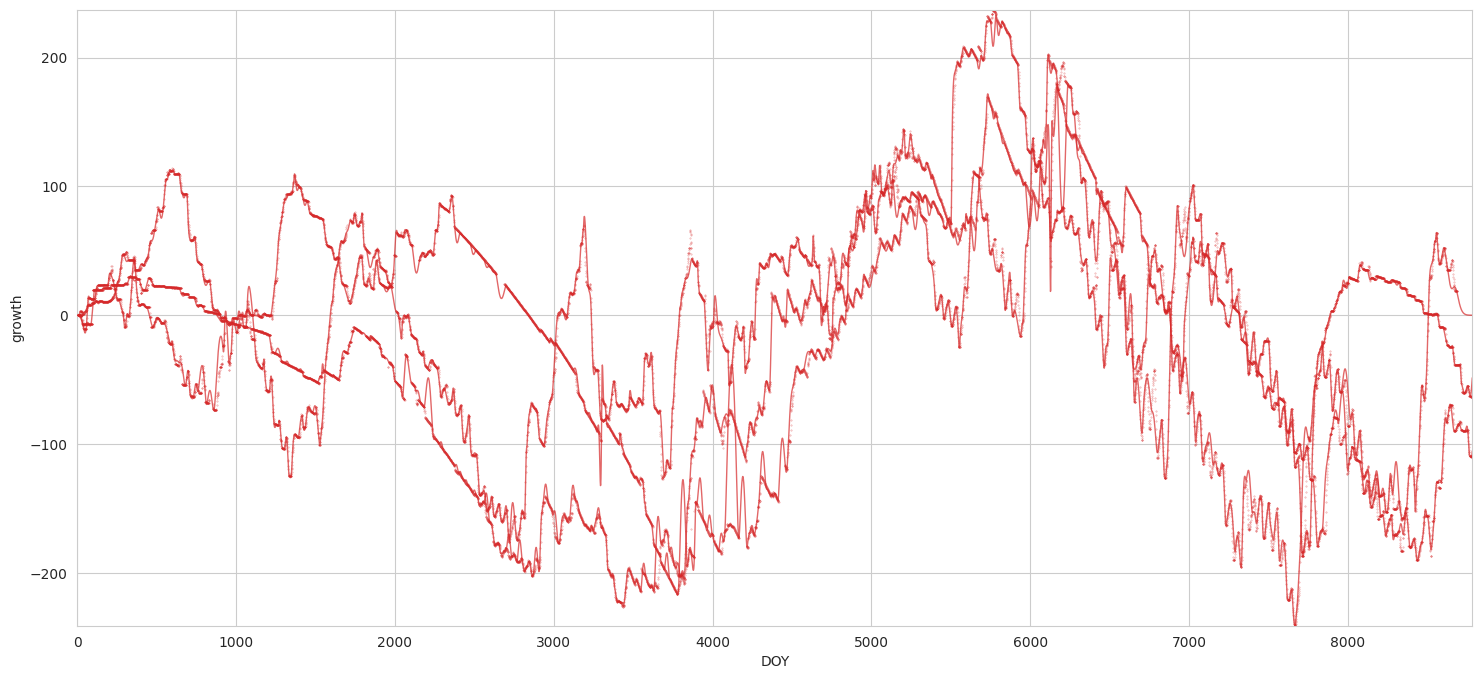

In [69]:
#tree = 'SH_076_2013'

plt.figure(figsize=(18, 8))

X_test = jnp.linspace(0, dendro.DOY.max(), 6000).reshape(-1, 1)

c = lambda s : 0 if s == "Beech" else (3 if s == "Sycamore" else 1)
for tree in tqdm(dendro.dendroNr.unique().tolist()[2:5]):
    df_ = dendro.loc[dendro.dendroNr.eq(tree)]

    idx_train = jnp.sort(jax.random.randint(jax.random.PRNGKey(0), (1000,), 0, len(df_.DOY) - 1))
    X_train = jnp.array(df_.DOY.iloc[idx_train].array).reshape(-1, 1)
    y_train = jnp.array(df_.deltagrowth.iloc[idx_train].array)

    # kernel_ = 65.3**2 * Matern(length_scale=25, length_scale_bounds=(2,16*48), nu = 2.5) + WhiteKernel(noise_level=0.1, noise_level_bounds="fixed") + ConstantKernel(0.4**2) * ExpSineSquared(0.1, 48, periodicity_bounds="fixed")
    # gp_model = gaussian_process.GaussianProcessRegressor(
    #     kernel=kernel_,
    #     n_restarts_optimizer=5,
    #     #normalize_y=True,
    #     optimizer=None
    # )

    def kernel_(x, y):
        #37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")
        return (MaternKernel32(65.3 ** 2, 25, x, y) + ExpSineSquaredKernel(0.4**2, 0.1, 48, x, y)) * WendlandTapering(3, 8*24, x, y)
    gp_model = GPR(X_train, y_train, kernel_, jnp.array([]), eps = 0.1)

    #gp_model.fit(X_train, y_train)
    mean_pred = gp_model.predict(X_test)

    # y_samples = gp_model.sample_y(X_test, 1)

    weibull_pred = 0#weibull_params[tree][0] * weibull_F(X_test.ravel(), *weibull_params[tree][1:3])

    plt.plot(X_test, mean_pred + weibull_pred, lw=1, zorder=10, alpha = .7, color=sns.color_palette()[c(df_.species.iloc[0])])

    plt.scatter(df_.DOY, df_.deltagrowth, lw=1, zorder=1, alpha = .5, color=sns.color_palette()[c(df_.species.iloc[0])], s = .1)

    # plt.fill_between(
    #     X_test.ravel(),
    #     mean_pred + weibull_pred - 1.96 * std_pred,
    #     mean_pred + weibull_pred + 1.96 * std_pred,
    #     alpha=.1, zorder=0, color=sns.color_palette("pastel")[c(df_.species.iloc[0])]
    # )

    # for idx, single_prior in enumerate(y_samples.T):
    #     plt.plot(
    #         X_test, single_prior + weibull_pred
    #         , alpha=.4, lw=1, linestyle="dashed", c=sns.color_palette("pastel")[c(df_.species.iloc[0])+idx]
    #     )

plt.xlabel("DOY")
plt.ylabel("growth")
plt.autoscale(tight=True)
plt.show()